In [34]:
import numpy as np
import pandas as pd

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('C:/RecoSys/Data/u.data', sep='\t', names=r_cols, encoding='latin-1')

ratings = ratings[['user_id', 'movie_id', 'rating']].astype(int)
ratings

,user_id,movie_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1
...,...,...,...
99995,880,476,3
99996,716,204,5
99997,276,1090,1
99998,13,225,2


In [16]:
np.array(ratings).nonzero()[1][:30]

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2, 0, 1, 2], dtype=int64)

In [21]:
#### (1)
# MF class
class MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings) # 실제 평점
        self.num_users, self.num_items = np.shape(self.R) # 사용자 수, 아이템 수
        self.K = K # 잠재 요인의 수
        self.alpha = alpha # learning_rate
        self.beta = beta # regularization
        self.iterations = iterations # 반복 횟수
        self.verbose = verbose # 학습과정 출력
        
    def rmse(self):
        '''현재 P,Q를 가지고 RMSE를 계산해 주는 함수'''
        xs ,ys = self.R.nonzero() # ratings에서 0이 아닌 index(x, y)
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys): # 평점이 있는 요소들 중에서
            prediction = self.get_prediction(x,y) # 사용자x, 아이템 y 각각에 대해서 평점 예측
            self.predictions.append(prediction)
            self.errors.append(self.R[x,y] - prediction) # 실제 값과 예측 값의 차이
        self.predictions = np.array(self.predictions) # list -> numpy array
        self.errors = np.array(self.errors) # list -> numpy array
        return np.sqrt(np.mean(self.errors**2))
    
    def train(self):
        '''
        정해진 반복 횟수(self.iterations)만큼 
        앞의 식(2), (4)를 사용해 
        P, Q, bu, bd값을 update하는 함수
        '''
        # Initialize user-feature(P) and movie-feature(Q) matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K)) # 평균:0, 표준편차:1/K
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K)) # 평균:0, 표준편차:1/K
        
        # Initalize the bias terms
        self.b_u = np.zeros(self.num_users) # user의 평가경향을 0으로 초기화
        self.b_d = np.zeros(self.num_items) # items의 평가경향
        self.b = np.mean(self.R[self.R.nonzero()]) # 전체 평균
        
        # List of training samples
        rows, columns = self.R.nonzero() # 평점이 있는 위치
        # SGD를 적용할 대상, 즉 평점이 있는 요소의 인덱스와 평점을 sample
        self.samples = [(i,j,self.R[i,j]) for i, j in zip(rows, columns)]
        
        
        # Stochastic Gradient Descent for given number pf iterations
        training_process = [] # SGD를 한 번 실행할 때마다 RMSE가 얼마나 개선되는지 기록
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd() # SGD 실행
            rmse = self.rmse() # SGD로 P, Q, b_u, b_d 업데이트 후 RMSE 계산
            training_process.append((i+1, rmse)) # 결과 저장
            if self.verbose:
                if (i+1)%10==0:
                    print("Iteration: %d ; Train RMSE = %.4f" %(i+1, rmse))
        return training_process
    
    # Rating prediction for user i and item j
    def get_prediction(self, i, j):
        '''평점 예측값을 구하는 함수'''
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
        return prediction
    
    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)
            
            # calculate gradient
            self.b_u[i] = self.b_u[i] + self.alpha * (e - self.beta*self.b_u[i])
            self.b_d[j] = self.b_d[j] + self.alpha * (e - self.beta*self.b_d[j])
            
            # update
            self.P[i, :] += self.alpha * (e * self.Q[j,:] - self.beta*self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i,:] - self.beta*self.Q[j,:])
            
    
        

In [22]:
# 전체 데이터 사용 MF
R_temp = ratings.pivot_table(values='rating', index='user_id', columns='movie_id').fillna(0)
mf = MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
train_process = mf.train()


Iteration: 10 ; Train RMSE = 0.9585
Iteration: 20 ; Train RMSE = 0.9374
Iteration: 30 ; Train RMSE = 0.9281
Iteration: 40 ; Train RMSE = 0.9226
Iteration: 50 ; Train RMSE = 0.9186
Iteration: 60 ; Train RMSE = 0.9149
Iteration: 70 ; Train RMSE = 0.9107
Iteration: 80 ; Train RMSE = 0.9051
Iteration: 90 ; Train RMSE = 0.8970
Iteration: 100 ; Train RMSE = 0.8858


In [35]:
#### (1)
# train test 분리
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings))
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [51]:
class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        #### (2) user_id, item_id를 R의 index와 매핑하기 위한 dictionary 생성 ####
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)        
        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)
        #### <<<< (2)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose
        
    def rmse(self):
        '''train set의 RMSE 계산'''
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs,ys):
            prediction = self.get_prediction(x,y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x,y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))
    
    def get_prediction(self, i, j):
        '''Ratings for user i and item j'''
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i,:].dot(self.Q[j,:].T)
        return prediction
    
    def sgd(self):
        # Stochastic gradient descent to get optimized P and Q matrix
        for i, j, r in self.samples:
            prediction = self.get_prediction(i,j)
            e = r - prediction
            
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])

            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])
            
### >>>> (3)
    # Test set을 선정
    def set_test(self, ratings_test):
        '''분리된 test set을 넘겨받아서 클래스 내부의 test set을 만드는 함수'''
        test_set = []
        for i in range(len(ratings_test)):
            
            x = self.user_id_index[ratings_test.iloc[i,0]] # user_id -> index
            y = self.item_id_index[ratings_test.iloc[i,1]] # movie_id -> index
            z = ratings_test.iloc[i,2] # rating(GT)
            test_set.append([x,y,z]) # 사용자, 아이템, 평점을 test_set에 추가
            self.R[x, y] = 0 # 해당 (사용자-아이템-평점)을 R에서 0으로 지운다 - MF모델을 학습하기 위해
        self.test_set = test_set
        return test_set
    
    def test_rmse(self):
        '''Test set의 RMSE 계산'''
        error = 0
        for one_set in self.test_set: # 0:사용자, 1:아이템, 2:평점
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))
    
    def test(self):
        # Initialize user_feature and item_feature matrix
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        
        # Initialize the bias terms
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])
        
        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse()
            rmse2 = self.test_rmse()
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print('Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f'
                          % (i+1, rmse1, rmse2))
                    
        return training_process
    
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])
    
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis, :] + self.P.dot(self.Q.T)
    

        
        

In [52]:
R_temp = ratings.pivot_table(values='rating', index='user_id', columns='movie_id').fillna(0)
mf = NEW_MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

Iteration: 10 ; Train RMSE = 0.9659 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9409 ; Test RMSE = 0.9644
Iteration: 30 ; Train RMSE = 0.9297 ; Test RMSE = 0.9566
Iteration: 40 ; Train RMSE = 0.9230 ; Test RMSE = 0.9523
Iteration: 50 ; Train RMSE = 0.9183 ; Test RMSE = 0.9496
Iteration: 60 ; Train RMSE = 0.9143 ; Test RMSE = 0.9477
Iteration: 70 ; Train RMSE = 0.9106 ; Test RMSE = 0.9463
Iteration: 80 ; Train RMSE = 0.9065 ; Test RMSE = 0.9449
Iteration: 90 ; Train RMSE = 0.9015 ; Test RMSE = 0.9434
Iteration: 100 ; Train RMSE = 0.8949 ; Test RMSE = 0.9415


In [53]:
# Printing predictions
print(mf.full_prediction())
print(mf.get_one_prediction(1, 2))

[[3.88490098 3.38839884 3.03755618 ... 3.34477122 3.45115242 3.44786011]
 [3.92041646 3.48142124 3.16078984 ... 3.42854467 3.5578442  3.55244445]
 [3.27554987 2.87445576 2.5246286  ... 2.82747368 2.93852652 2.92029115]
 ...
 [4.18764937 3.77758068 3.4333856  ... 3.71099818 3.83343452 3.83361401]
 [4.3194259  3.90157562 3.55790867 ... 3.83187249 3.96248826 3.94630063]
 [3.78910624 3.38119911 3.01990913 ... 3.29610175 3.41834819 3.39370105]]
3.388398840960325


In [54]:
# 최적의 K값 찾기
results = []
index = []
for K in range(50,261,10):
    print('K=',K)
    R_temp = ratings.pivot_table(values='rating', index='user_id', columns='movie_id').fillna(0)
    mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.01, iterations=300, verbose=True)
    test_set = mf.set_test(ratings_test)
    result = mf.test()
    index.append(K)
    results.append(result)

K= 50
Iteration: 10 ; Train RMSE = 0.9658 ; Test RMSE = 0.9832
Iteration: 20 ; Train RMSE = 0.9411 ; Test RMSE = 0.9643
Iteration: 30 ; Train RMSE = 0.9301 ; Test RMSE = 0.9565
Iteration: 40 ; Train RMSE = 0.9236 ; Test RMSE = 0.9522
Iteration: 50 ; Train RMSE = 0.9191 ; Test RMSE = 0.9496
Iteration: 60 ; Train RMSE = 0.9155 ; Test RMSE = 0.9478
Iteration: 70 ; Train RMSE = 0.9121 ; Test RMSE = 0.9463
Iteration: 80 ; Train RMSE = 0.9083 ; Test RMSE = 0.9450
Iteration: 90 ; Train RMSE = 0.9036 ; Test RMSE = 0.9436
Iteration: 100 ; Train RMSE = 0.8972 ; Test RMSE = 0.9417
Iteration: 110 ; Train RMSE = 0.8882 ; Test RMSE = 0.9391
Iteration: 120 ; Train RMSE = 0.8762 ; Test RMSE = 0.9356
Iteration: 130 ; Train RMSE = 0.8610 ; Test RMSE = 0.9315
Iteration: 140 ; Train RMSE = 0.8433 ; Test RMSE = 0.9274
Iteration: 150 ; Train RMSE = 0.8237 ; Test RMSE = 0.9238
Iteration: 160 ; Train RMSE = 0.8027 ; Test RMSE = 0.9210
Iteration: 170 ; Train RMSE = 0.7804 ; Test RMSE = 0.9191
Iteration: 180 ; 

KeyboardInterrupt: 

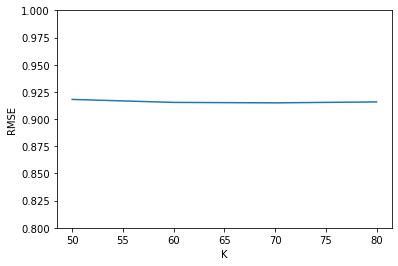

In [55]:
# 최적의 iteration
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j+1, RMSE[j]])
    
# 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(index, [x[2] for x in summary])
plt.ylim(0.8, 1.0)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show()